In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [251]:
data = pd.concat([pd.read_csv(f'data/rosters.nosync/rosters_{year}.csv') for year in np.arange(2015, 2026)]).reset_index(drop = True)

In [252]:
features = []
for f in ['PTS', 'FGA', 'MP', 'USG%']:
    for w in [1, 5, 10, 15, 20] :
        data[f'{f}_{w}'] = data.groupby('player_id')[f'{f}'].rolling(w, min_periods = 1).mean().reset_index(level = 0, drop = True)
        data[f'{f}_{w}'] = data.groupby('player_id')[f'{f}_{w}'].shift()
        features.append(f'{f}_{w}')

In [253]:
data['PTS_avg'] = data.groupby('player_id')['PTS'].rolling(100, min_periods = 1).mean().reset_index(level = 0, drop = True)
data['PTS_avg'] = data.groupby('player_id')['PTS_avg'].shift()

In [254]:
data_full = pd.DataFrame(np.tile(data, (10, 1)))
data_full.columns = data.columns
data_full.dropna(inplace = True)

In [255]:
data_full['thres'] = np.random.poisson(data_full['PTS_avg']) + .5
data_full.drop_duplicates(inplace = True)
data_full['target'] = (data_full['PTS'] > data_full['thres']).astype(int)

In [256]:
data_full['Year'] = data_full['game_id'].str[:4].astype(int)

In [257]:
train = data_full.copy()[
    (data_full['Year'] > 2014)
    & (data_full['Year'] < 2024)
]

test = data_full.copy()[
    data_full['Year'] >= 2024
]

In [258]:
import tensorflow as tf
from tensorflow.keras import layers, Model

n = len(features)
k = 5

# Define input layers
inputs = layers.Input(shape=(n+1,), name="features")  # Input for n features

# Classification layers
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dense(n+1, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

# Define the model
model = Model(inputs = inputs, outputs = output)

# Compile the model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 21)             │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731 (2.86 KB)

 Trainable params: 731 (2.86 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
X_train = train[features + ['thres']].to_numpy().astype(np.float32)
X_test = test[features + ['thres']].to_numpy().astype(np.float32)
y_train = train['target'].to_numpy()
y_test = test['target'].to_numpy()

In [260]:
history = model.fit(
    X_train, y_train,           
    epochs = 6,                      
    batch_size=128,                                                  
    verbose=1                            
)

Epoch 1/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 349us/step - accuracy: 0.6739 - loss: 0.6524
Epoch 2/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 380us/step - accuracy: 0.6928 - loss: 0.5800
Epoch 3/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 337us/step - accuracy: 0.6933 - loss: 0.5787
Epoch 4/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.6940 - loss: 0.5780
Epoch 5/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 331us/step - accuracy: 0.6948 - loss: 0.5775
Epoch 6/6
11731/11731 ━━━━━━━━━━━━━━━━━━━━ 4s 345us/step - accuracy: 0.6953 - loss: 0.5769


In [261]:
y_pred = model.predict(X_test)

5785/5785 ━━━━━━━━━━━━━━━━━━━━ 1s 187us/step


In [262]:
test['pred'] = y_pred

In [267]:
test.sort_values(['game_id', 'player_id', 'thres'])[['Player', 'Year', 'PTS', 'PTS_avg', 'thres', 'target', 'pred']].sort_values('pred').head(20)

,Player,Year,PTS,PTS_avg,thres,target,pred
1845828,Bojan Bogdanović,2024,9,19.91,38.5,0,0.002745
1314072,Jaden Hardy,2024,4,8.38,23.5,0,0.003982
1837063,KJ Martin,2024,0,10.24,20.5,0,0.005010
2378902,Mason Plumlee,2024,5,9.27,21.5,0,0.006178
2382774,Bojan Bogdanović,2024,13,18.26,31.5,0,0.007218
259191,Cole Anthony,2024,2,10.63,22.5,0,0.007364
2648243,Bojan Bogdanović,2024,14,18.49,29.5,0,0.007491
1047179,Mason Plumlee,2024,0,9.63,20.5,0,0.007920
2368389,Brandon Ingram,2024,13,23.38,42.5,0,0.008034
782032,KJ Martin,2024,11,8.61,19.5,0,0.008323


In [264]:
thres = np.arange(0.5, 40.5)
X = np.tile(data_full[features].mean(axis = 0).to_numpy().reshape(1, -1), (len(thres), 1))
X = np.hstack((X, thres.reshape(-1, 1))).astype(np.float32)

In [19]:
plt.plot(thres, model.predict(X), 'k-o')

NameError: name 'plt' is not defined

In [1]:
import pandas as pd
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import requests
import os
import json

from helpers.scrape import get_rotowire_lineups, get_lineups

# from helpers.email import send_email

if os.getenv("GITHUB_ACTIONS") == "true" :
  api_key = os.getenv('ODDS_API_KEY')
else :
  with open('secrets/odds_api_key.txt') as f:
    api_key = f.read()

with open('utils/odds_tm_map.json', 'r') as f :
  odds_tm_map = json.load(f)

games = pd.read_csv('data/games.csv')

In [4]:
games_now = games[games['Date'] == '2025-01-22']
games_now

,game_id,Date,Time,Home,Away,event_id,insert_timestamp_utc
392,202501220ATL,2025-01-22,2025-01-22 19:30:00,ATL,DET,33f7be6747a15f9e36d7341863907c5d,2025-01-22 14:17:27.192883+00:00
393,202501220BRK,2025-01-22,2025-01-22 19:30:00,BRK,PHO,08506118721a1523d1e2b26c11676ec8,2025-01-22 14:17:27.192883+00:00
394,202501220DAL,2025-01-22,2025-01-22 19:30:00,DAL,MIN,d2036bb7eb58c7f9937efcb77d7f7ee0,2025-01-22 14:17:27.192883+00:00
395,202501220HOU,2025-01-22,2025-01-22 20:00:00,HOU,CLE,d6ff21cfce2a414242fea9331804aa85,2025-01-22 14:17:27.192883+00:00
396,202501220MEM,2025-01-22,2025-01-22 20:00:00,MEM,CHO,d34a1f613c8fe3424990ff71939ac227,2025-01-22 14:17:27.192883+00:00
397,202501220NOP,2025-01-22,2025-01-22 20:00:00,NOP,MIL,9fa9fd46fe842a25a4178e3b2d702cd9,2025-01-22 14:17:27.192883+00:00
398,202501220OKC,2025-01-22,2025-01-22 20:00:00,OKC,UTA,747ca0e15fb940c8a282bd30256a1461,2025-01-22 14:17:27.192883+00:00
399,202501220SAC,2025-01-22,2025-01-22 22:00:00,SAC,GSW,baf880617d80ad47bab4a447513aa1d2,2025-01-22 14:17:27.192883+00:00
400,202501220LAC,2025-01-22,2025-01-22 22:30:00,LAC,BOS,5960906d79cf1ed09329d2cd861c6dce,2025-01-22 14:17:27.192883+00:00


In [17]:
eventId = '33f7be6747a15f9e36d7341863907c5d'

odds_response = requests.get(f'https://api.the-odds-api.com/v4/sports/basketball_nba/events/{eventId}/odds',
                             params = {'apiKey': 'a7bfde5bb651ac64e61f99c67631ef47',
                                       'regions': 'us',
                                    #    'markets': ['player_points', 'player_assists'],
                                       'markets': 'player_points',
                                       'bookmakers': 'underdog',
                                       'oddsFormat': 'american'})

In [18]:
for player in odds_response.json()['bookmakers'][0]['markets'][0]['outcomes']:
    print(player['description'], player['point'], player['price'])

Trae Young 26.5 -137
Trae Young 26.5 -137
Cade Cunningham 26.5 -137
Cade Cunningham 26.5 -137
Tobias Harris 14.5 -137
Tobias Harris 14.5 -137
Ausar Thompson 9.5 -137
Ausar Thompson 9.5 -137
Jalen Johnson 18.5 -137
Jalen Johnson 18.5 -137
Jalen Duren 10.5 -137
Jalen Duren 10.5 -137
Onyeka Okongwu 12.5 -137
Onyeka Okongwu 12.5 -137
Dyson Daniels 13.5 -137
Dyson Daniels 13.5 -137


In [12]:
odds_response.json()['bookmakers']

[{'key': 'underdog',
  'title': 'Underdog',
  'markets': [{'key': 'player_points',
    'last_update': '2025-01-22T15:57:19Z',
    'outcomes': [{'name': 'Over',
      'description': 'Kevin Durant',
      'price': -137,
      'point': 26.5},
     {'name': 'Under',
      'description': 'Kevin Durant',
      'price': -137,
      'point': 26.5},
     {'name': 'Over',
      'description': 'Devin Booker',
      'price': -137,
      'point': 25.5},
     {'name': 'Under',
      'description': 'Devin Booker',
      'price': -137,
      'point': 25.5},
     {'name': 'Over',
      'description': 'Bradley Beal',
      'price': -137,
      'point': 13.5},
     {'name': 'Under',
      'description': 'Bradley Beal',
      'price': -137,
      'point': 13.5},
     {'name': 'Over',
      'description': 'Tyus Jones',
      'price': -137,
      'point': 9.5},
     {'name': 'Under',
      'description': 'Tyus Jones',
      'price': -137,
      'point': 9.5},
     {'name': 'Over', 'description': 'Ryan Dunn'

In [ ]:

# # Store subset of games in the next 30 minutes
# now = datetime.now((ZoneInfo('US/Eastern')))
# print(now.strftime('%H:%M:%S'))
# today_dt = now.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
# games_now = games[(games['Time'] >= now.strftime(f'%Y-%m-%d')  + f' {start_time}:00:00') & (games['Time'] < now.strftime(f'%Y-%m-%d')  + f' {start_time+3}:00:00')]

rotowire_soup = get_rotowire_lineups()
rw_t = datetime.now()

# Iterate through games
for _, game in games_now.iterrows() :

    eventId = game['event_id']
    tm = game['game_id'][-3:]
    print(f'Querying game {game["game_id"]}...')

    odds_response = requests.get(f'https://api.the-odds-api.com/v4/sports/basketball_nba/events/{eventId}/odds',
                             params = {'apiKey': api_key,
                                       'regions': 'us',
                                       'markets': 'player_first_basket',
                                       'oddsFormat': 'decimal'})
    
    bm_dfs = [pd.DataFrame(columns = ['name', 'price', 'bookmaker', 'update_time'])]

    for bookmaker in odds_response.json()['bookmakers'] :
        
        bm_df = pd.DataFrame(bookmaker['markets'][0]['outcomes'])
        bm_df['bookmaker'] = bookmaker['key']
        bm_df['update_time'] = bookmaker['markets'][0]['last_update']

        print(f'\tFound {len(bm_df)} lines from {bookmaker["key"]}')

        bm_dfs.append(
            bm_df
            .drop(columns = 'name')
            .rename(columns = {'description': 'name'})
        )

    game_df = pd.concat(bm_dfs).reset_index(drop = True)
    game_df['game_id'] = game['game_id']
    game_df['event_id'] = game['event_id']

    game_df['insert_timestamp_utc'] = datetime.now(timezone.utc)
    game_df.to_csv('data/odds_first_basket.csv', index = None, header = None, mode = 'a')

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [15]:

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

In [16]:
# Define the autoencoder
input_img = Input(shape = (28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [19]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 555,653 (2.12 MB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 370,436 (1.41 MB)

In [17]:
# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, validation_data=(x_test, x_test))

# Encode and decode some images
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.1210 - val_loss: 0.1140
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/10
  9/235 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - loss: 0.1129

KeyboardInterrupt: 

In [20]:
decoded_imgs = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


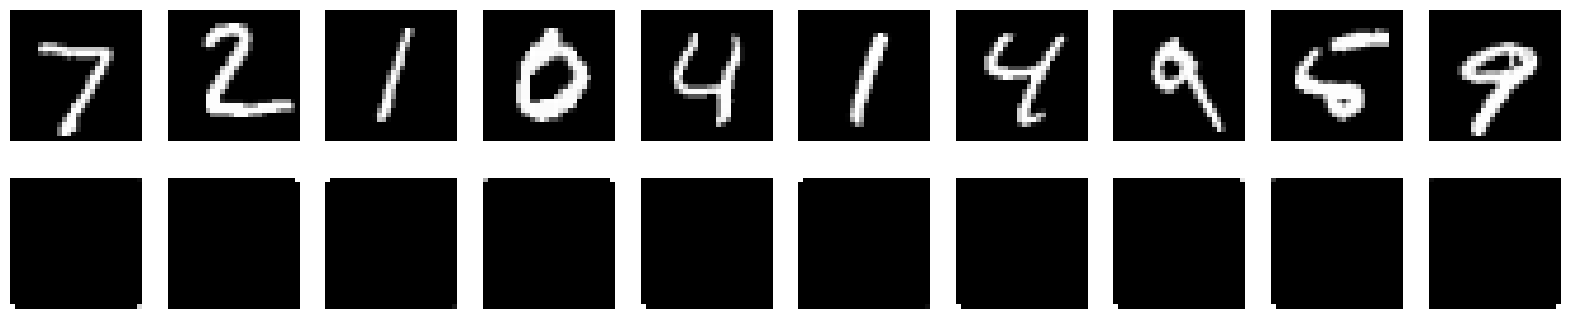

In [21]:

# Display original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()